In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
bike_trips = pd.read_csv('201902-fordgobike-tripdata.csv')
bike_trips.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


# Exploring data quality and cleaning

In [6]:
bike_trips.shape

(183412, 16)

In [7]:
bike_trips.isna().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

In [8]:
bike_trips['start_time'] = pd.to_datetime(bike_trips['start_time'])
bike_trips['end_time'] = pd.to_datetime(bike_trips['end_time'])

## New Variables

### Duration as minute

In [9]:
bike_trips['duration_min'] = bike_trips['duration_sec'] / 60

### Derived time variables

In [10]:
bike_trips['start_hour'] = bike_trips['start_time'].dt.hour
bike_trips['end_hour'] = bike_trips['end_time'].dt.hour
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
bike_trips['weekday'] = pd.Categorical(bike_trips['start_time'].dt.day_name(), weekdays, ordered=True)
bike_trips['weekend'] = bike_trips['weekday'].isin(['Saturday', 'Sunday'])
bike_trips['overnight_use'] = bike_trips['start_time'].dt.day != bike_trips['end_time'].dt.day

### Distance as km derived from locations

In [11]:
# From https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

bike_trips['distance'] = haversine(bike_trips['start_station_latitude'], bike_trips['start_station_longitude'],
                                  bike_trips['end_station_latitude'], bike_trips['end_station_longitude'], True)

### Group age into ordered categories

In [12]:
age_group = np.round((bike_trips['start_time'].dt.year - bike_trips['member_birth_year']) / 10) * 10
age_group = age_group.astype(str).str.replace(r'\.0', 's', regex=True)
age_groups_categories = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
bike_trips['member_age_group'] = pd.Categorical(age_group, categories=age_groups_categories, ordered=True)

In [13]:
bike_trips['member_age_group'].isna().mean()

0.045471397727520554

### Group latitude and longitude into categories

#### Steps
- What are the minimum and maximun for start and stop?
- How many blocks to divied?
- How to label?

In [14]:
coordinate_columns = [column for column in bike_trips.columns 
    if 'latitude' in column or 'longitude' in column]
latitude_columns = [column for column in bike_trips.columns if 'latitude' in column]
longitude_columns = [column for column in bike_trips.columns if 'longitude' in column]
bike_trips[coordinate_columns].describe()

,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
count,183412.000000,183412.000000,183412.000000,183412.000000
mean,37.771223,-122.352664,37.771427,-122.352250
std,0.099581,0.117097,0.099490,0.116673
min,37.317298,-122.453704,37.317298,-122.453704
25%,37.770083,-122.412408,37.770407,-122.411726
50%,37.780760,-122.398285,37.781010,-122.398279
75%,37.797280,-122.286533,37.797320,-122.288045
max,37.880222,-121.874119,37.880222,-121.874119


In [15]:
latitude_min = bike_trips[latitude_columns].dropna().min().min()
longitude_min = bike_trips[longitude_columns].dropna().min().min()
latitude_max = bike_trips[latitude_columns].max().max()
longitude_max = bike_trips[longitude_columns].max().max()

latitude_min, latitude_max, longitude_min, longitude_max

(37.3172979, 37.88022244590679, -122.45370447635652, -121.8741186)

In [16]:
latitude_step, longitude_step = 0.05, 0.05
latitude_cuts = np.arange(latitude_min - latitude_step, latitude_max + latitude_step, latitude_step)
longitude_cuts = np.arange(longitude_min - latitude_step, longitude_max + longitude_step, longitude_step)
print(latitude_cuts)
print(longitude_cuts)
latitude_cuts.shape, longitude_cuts.shape

[37.2672979 37.3172979 37.3672979 37.4172979 37.4672979 37.5172979
 37.5672979 37.6172979 37.6672979 37.7172979 37.7672979 37.8172979
 37.8672979 37.9172979]
[-122.50370448 -122.45370448 -122.40370448 -122.35370448 -122.30370448
 -122.25370448 -122.20370448 -122.15370448 -122.10370448 -122.05370448
 -122.00370448 -121.95370448 -121.90370448 -121.85370448]


((14,), (14,))

In [17]:
bike_trips['start_station_lat_group'] = pd.cut(bike_trips['start_station_latitude'], latitude_cuts)
bike_trips['start_station_long_group'] = pd.cut(bike_trips['start_station_longitude'], longitude_cuts)
bike_trips['end_station_lat_group'] = pd.cut(bike_trips['end_station_latitude'], latitude_cuts)
bike_trips['end_station_long_group'] = pd.cut(bike_trips['end_station_longitude'], longitude_cuts)

### Subsetting to get the short trips

In [18]:
short_trips = bike_trips[bike_trips['duration_min'] < 60]

In [19]:
short_trips.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,end_hour,weekday,weekend,overnight_use,distance,member_age_group,start_station_lat_group,start_station_long_group,end_station_lat_group,end_station_long_group
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,...,0,Thursday,False,True,2.409301,40s,"(37.767, 37.817]","(-122.304, -122.254]","(37.767, 37.817]","(-122.254, -122.204]"
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,323.0,Broadway at Kearny,37.798014,...,0,Thursday,False,True,3.332203,60s,"(37.767, 37.817]","(-122.404, -122.354]","(37.767, 37.817]","(-122.454, -122.404]"
6,1147,2019-02-28 23:55:35.104,2019-03-01 00:14:42.588,300.0,Palm St at Willow St,37.317298,-121.884995,312.0,San Jose Diridon Station,37.329732,...,0,Thursday,False,True,2.028551,40s,"(37.267, 37.317]","(-121.904, -121.854]","(37.317, 37.367]","(-121.904, -121.854]"
7,1615,2019-02-28 23:41:06.766,2019-03-01 00:08:02.756,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,...,0,Thursday,False,True,4.532568,30s,"(37.767, 37.817]","(-122.454, -122.404]","(37.717, 37.767]","(-122.454, -122.404]"
8,1570,2019-02-28 23:41:48.790,2019-03-01 00:07:59.715,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,...,0,Thursday,False,True,4.532568,30s,"(37.767, 37.817]","(-122.454, -122.404]","(37.717, 37.767]","(-122.454, -122.404]"


# Univariate Explorations 

In [20]:
base_color = sns.color_palette()[0]

## How is duration distributed?

In [21]:
bike_trips['duration_sec'].describe()

count    183412.000000
mean        726.078435
std        1794.389780
min          61.000000
25%         325.000000
50%         514.000000
75%         796.000000
max       85444.000000
Name: duration_sec, dtype: float64

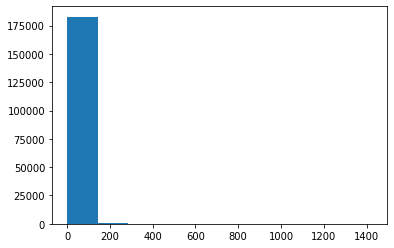

In [22]:
plt.hist(bike_trips['duration_min']);

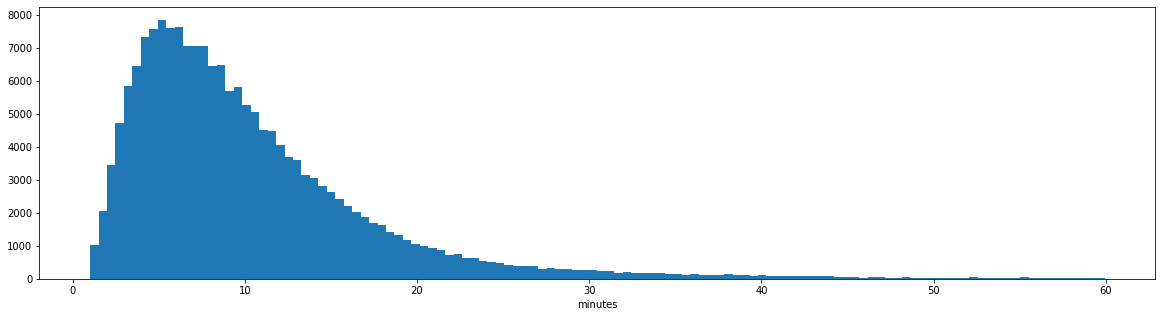

In [23]:
plt.figure(figsize=(20, 5))
plt.hist(short_trips['duration_min'], bins=120)
plt.xlabel('minutes');

In [24]:
bike_trips.duration_sec.max() / 3600

23.734444444444446

## How are  start time and end time distrubuted?

<AxesSubplot:xlabel='start_hour', ylabel='count'>

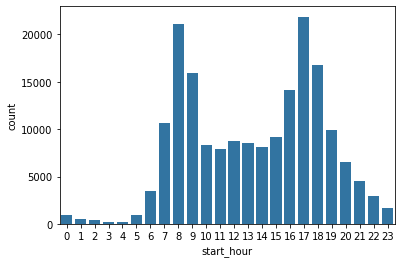

In [25]:
sns.countplot(data=bike_trips, x='start_hour', color=base_color)

<AxesSubplot:xlabel='end_hour', ylabel='count'>

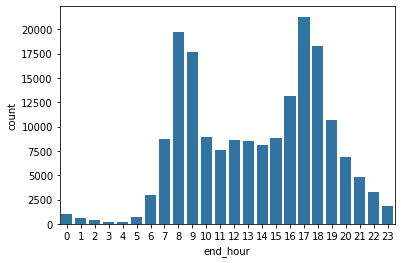

In [26]:
sns.countplot(data=bike_trips, x='end_hour', color=base_color)

<AxesSubplot:xlabel='weekday', ylabel='count'>

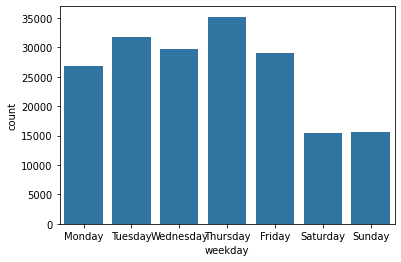

In [27]:
sns.countplot(data=bike_trips, x='weekday', color=base_color)

In [28]:
bike_trips.overnight_use.value_counts()

False    183092
True        320
Name: overnight_use, dtype: int64

## How are the start stations and end stations ids distributed?

In [29]:
bike_trips['start_station_id'].nunique()

329

In [30]:
set(bike_trips['start_station_id'].unique()) - set(bike_trips['end_station_id'].unique()) 

{nan}

In [31]:
set(bike_trips['end_station_id'].unique()) - set(bike_trips['start_station_id'].unique()) 

{nan}

In [32]:
(bike_trips['start_station_id'] == bike_trips['end_station_id']).mean()

0.02083833118879899

<AxesSubplot:>

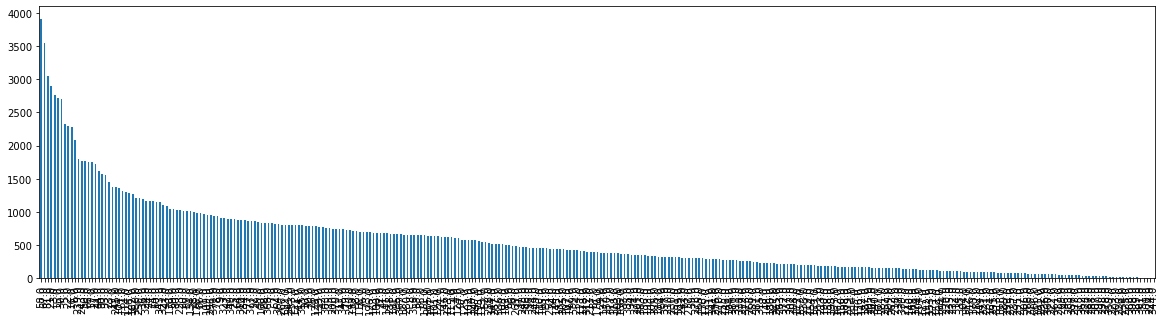

In [33]:
plt.figure(figsize=(20, 5))
bike_trips['start_station_id'].value_counts().plot.bar()

There a few stations with more thant thousand rides, done. Let's subset them

<AxesSubplot:>

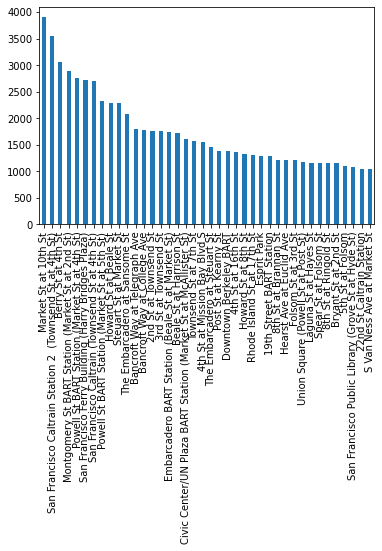

In [34]:
bike_trips['start_station_name'].value_counts()[:40].plot.bar()

## Distance 

In [35]:
bike_trips['distance'].describe()

count    183412.000000
mean          1.690659
std           1.097589
min           0.000000
25%           0.910955
50%           1.430738
75%           2.225687
max          69.469241
Name: distance, dtype: float64

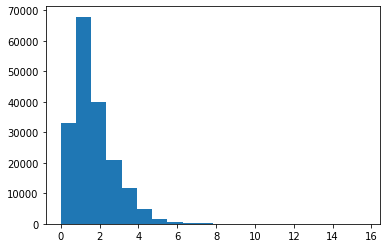

In [36]:
plt.hist(data=short_trips, x='distance', bins=20);

## Do all bikes get equal use or are some used more than others?

In [37]:
bike_trips['bike_id'].nunique()

4646

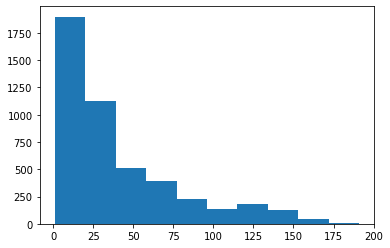

In [38]:
plt.hist(bike_trips['bike_id'].value_counts().values);

## Which type of user rides more?

In [39]:
bike_trips['user_type'].value_counts()

Subscriber    163544
Customer       19868
Name: user_type, dtype: int64

In [40]:
bike_trips['member_birth_year'].isna().value_counts()

False    175147
True       8265
Name: member_birth_year, dtype: int64

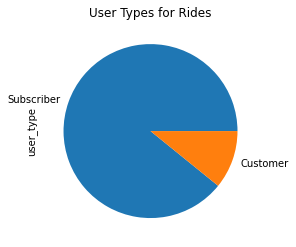

In [41]:
bike_trips['user_type'].value_counts().plot.pie()
plt.title('User Types for Rides');

## Member Age Group

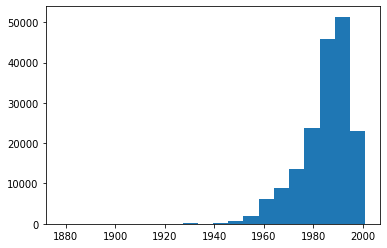

In [42]:
plt.hist(data=bike_trips, x='member_birth_year', bins=20);

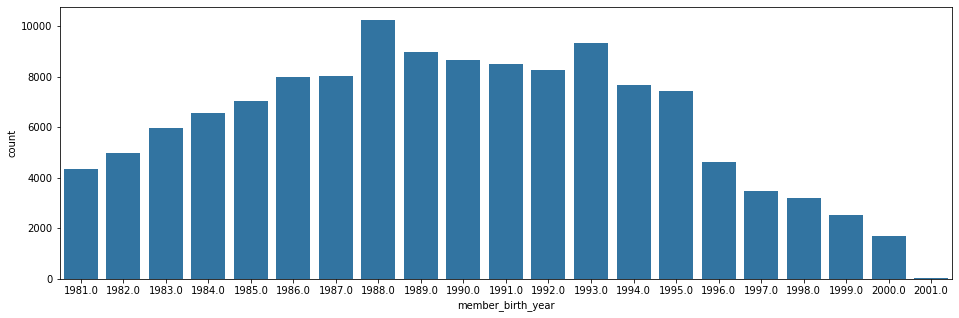

In [43]:
plt.figure(figsize=(16, 5))
sns.countplot(
    data=bike_trips[bike_trips['member_birth_year'] > 1980],
    x='member_birth_year',
    color=base_color
);

<AxesSubplot:>

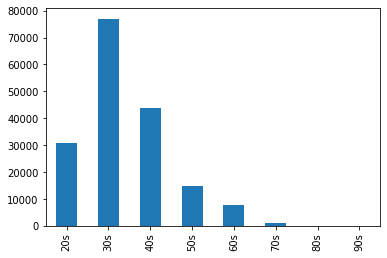

In [44]:
bike_trips.member_age_group.value_counts().sort_index().plot.bar()

## Member Gender

<AxesSubplot:ylabel='member_gender'>

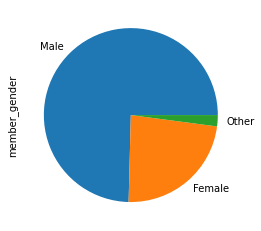

In [45]:
bike_trips.member_gender.value_counts().plot.pie()

## What fraction are Bike Share For All rides?

<AxesSubplot:>

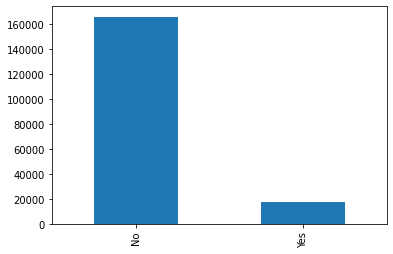

In [46]:
bike_trips['bike_share_for_all_trip'].value_counts().plot.bar()

# Bivariate Exploration

### Which location gets the most trips?

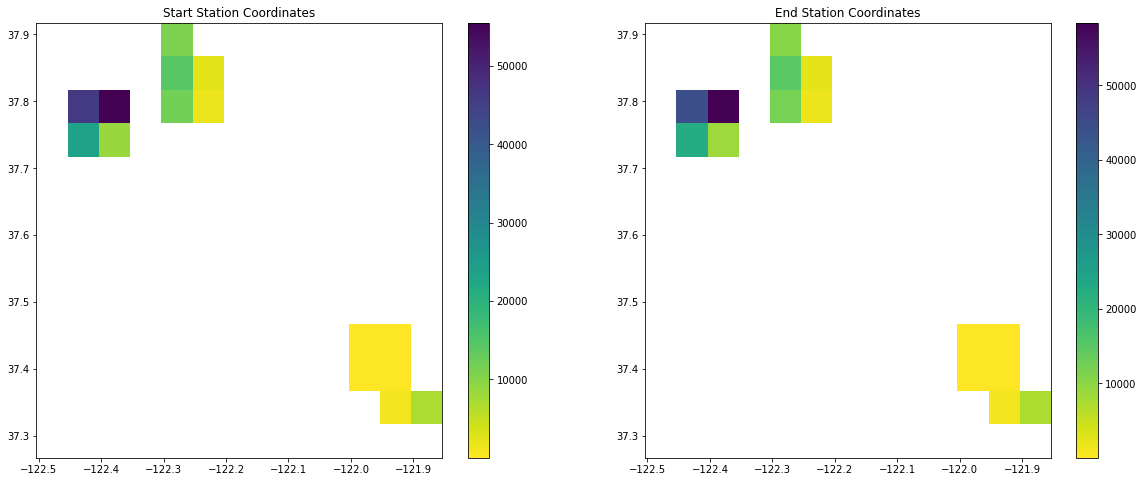

In [73]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist2d(
    data=bike_trips, 
    x='start_station_longitude', 
    y='start_station_latitude',
    #bins=(20, 20),
    bins=(longitude_cuts, latitude_cuts),
    cmap='viridis_r',
    cmin=1
)
plt.colorbar()
plt.title('Start Station Coordinates')
plt.subplot(1, 2, 2)
plt.hist2d(
    data=bike_trips, 
    x='end_station_longitude', 
    y='end_station_latitude',
    #bins=(20, 20),
    bins=(longitude_cuts, latitude_cuts),
    cmap='viridis_r',
    cmin=1
)
plt.colorbar()
plt.title('End Station Coordinates');

## Which variables affect duration?

<AxesSubplot:xlabel='duration_sec', ylabel='distance'>

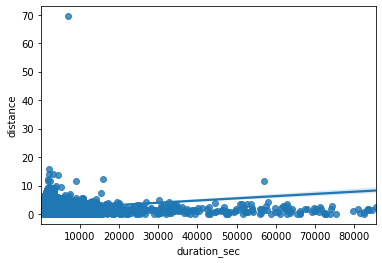

In [50]:
sns.regplot(data=bike_trips, x='duration_sec', y='distance')

<AxesSubplot:xlabel='duration_sec', ylabel='distance'>

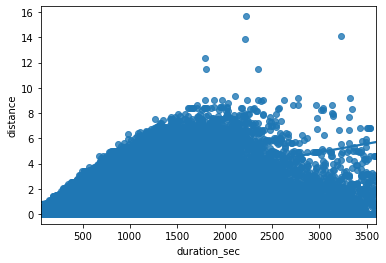

In [75]:
sns.regplot(data=short_trips, x='duration_sec', y='distance')

(6.0, 23.0)

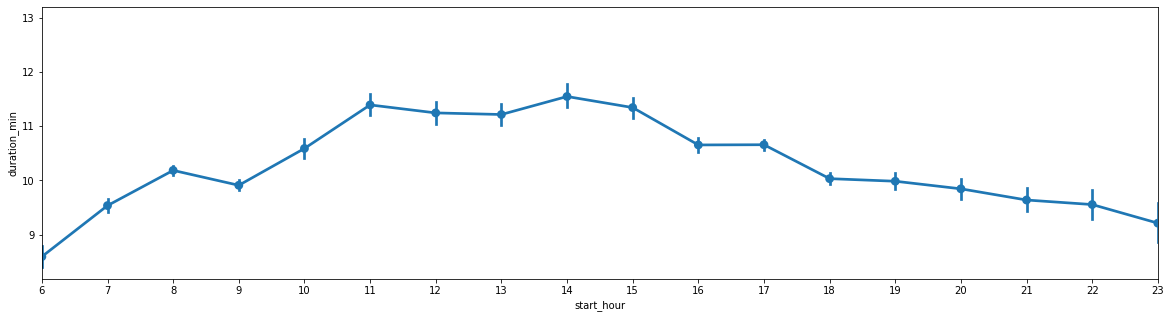

In [51]:
plt.figure(figsize=(20, 5))
sns.pointplot(data=short_trips, x='start_hour', y='duration_min')
plt.xlim(6, 23)

<AxesSubplot:xlabel='member_age_group', ylabel='duration_min'>

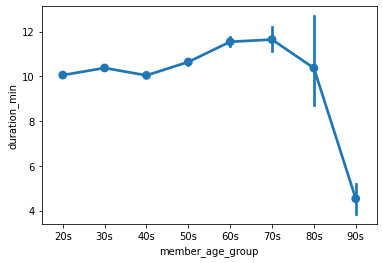

In [52]:
sns.pointplot(data=short_trips, x='member_age_group', y='duration_min')

<AxesSubplot:xlabel='member_gender', ylabel='duration_min'>

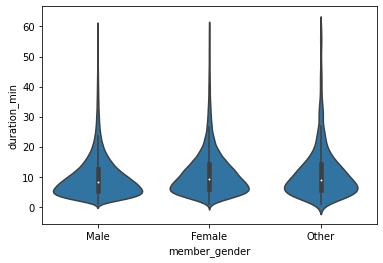

In [53]:
sns.violinplot(data=short_trips, x='member_gender', y='duration_min', color=base_color)

<AxesSubplot:xlabel='weekday', ylabel='duration_min'>

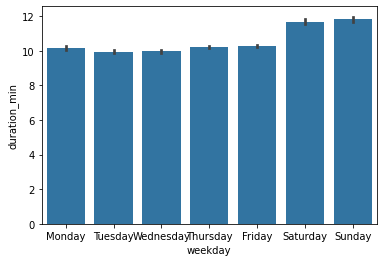

In [54]:
sns.barplot(data=short_trips, x='weekday', y='duration_min', color=base_color)

<AxesSubplot:xlabel='overnight_use', ylabel='duration_min'>

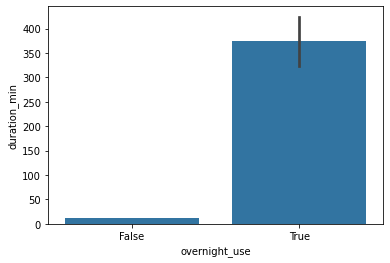

In [74]:
sns.barplot(data=bike_trips, x='overnight_use', y='duration_min', color=base_color)

<AxesSubplot:xlabel='bike_share_for_all_trip', ylabel='duration_min'>

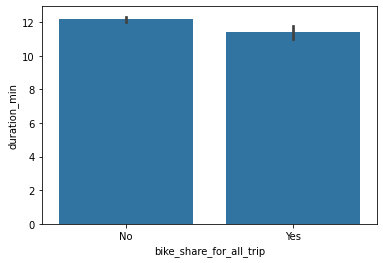

In [62]:
sns.barplot(data=bike_trips, x='bike_share_for_all_trip', y='duration_min', color=base_color)

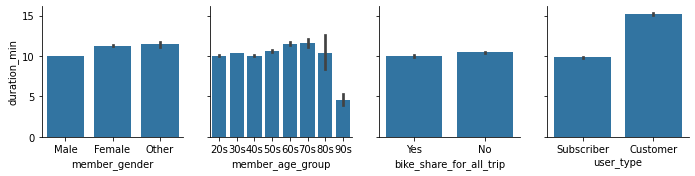

In [61]:
g = sns.PairGrid(
    data=short_trips, 
    y_vars=['duration_min'], 
    x_vars=['member_gender', 'member_age_group', 'bike_share_for_all_trip', 'user_type']
)
g.map(sns.barplot, color=base_color)

## Multivariate Plotting

### Age, Gender and Duration

<AxesSubplot:xlabel='member_age_group', ylabel='duration_min'>

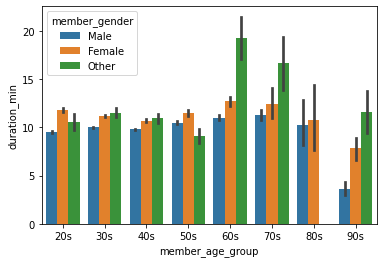

In [58]:
sns.barplot(data=short_trips, x='member_age_group', hue='member_gender', y='duration_min')

<AxesSubplot:xlabel='member_age_group', ylabel='duration_min'>

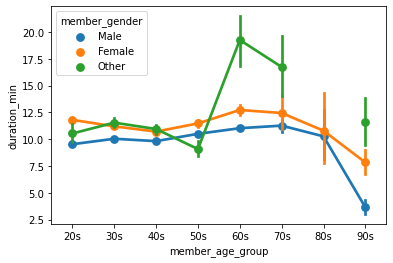

In [59]:
sns.pointplot(data=short_trips, x='member_age_group', hue='member_gender', y='duration_min')